In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Bangkitproject/tomatodataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-

In [3]:
# Import Library
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import confusion_matrix, classification_report
from keras.regularizers import l2


In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Directory Path
train_dir = '/content/tomato/train'
val_dir='/content/tomato/val'

In [6]:
# List of classes
classes = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
           'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
num_classes = len(classes)

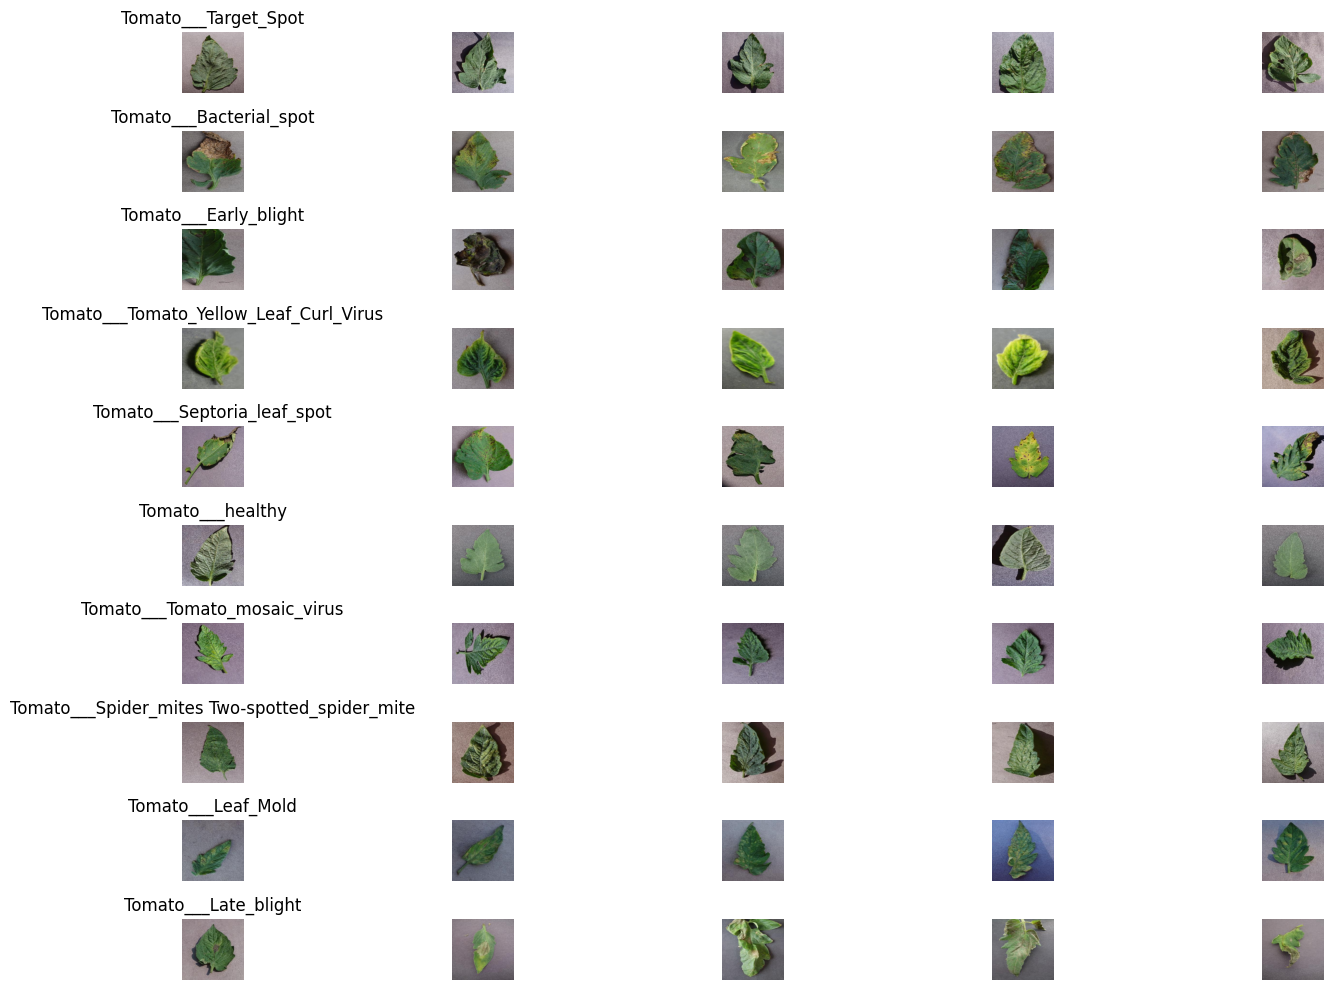

In [7]:
categories = os.listdir(train_dir)

plt.figure(figsize=(15, 10))
num_categories = len(categories)

for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    image_files = os.listdir(category_path)[:5]

    for j, file in enumerate(image_files):
        img_path = os.path.join(category_path, file)
        img = load_img(img_path)
        plt.subplot(num_categories, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.title(category)

plt.tight_layout()
plt.show()

In [18]:
# Menyiapkan data generator untuk augmentasi dan pra-pemrosesan data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Skalasi nilai pixel ke rentang [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Mendefinisikan generator untuk data train dan data validasi
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Ganti dengan path direktori data train
        target_size=(150, 150),  # Ukuran gambar yang diharapkan
        batch_size=32,
        class_mode='categorical', # Mode kelas untuk klasifikasi multiclass
        classes=classes)

validation_generator = val_datagen.flow_from_directory(
        val_dir,  # Ganti dengan path direktori data validasi
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical', # Mode kelas untuk klasifikasi multiclass
        classes=classes)

# Membangun arsitektur model CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Jumlah kelas output
])

# Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,061,578 (4.05 MB)

 Trainable params: 1,061,578 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Melatih model
history=model.fit(
      train_generator,
      epochs=100,
      validation_data=validation_generator)

# Simpan model
model.save('tomato_disease_classifier_revised.h5')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 251ms/step - accuracy: 0.1167 - loss: 2.4234 - val_accuracy: 0.2620 - val_loss: 1.9577
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 233ms/step - accuracy: 0.2427 - loss: 2.0027 - val_accuracy: 0.2760 - val_loss: 1.8998
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 227ms/step - accuracy: 0.3531 - loss: 1.7751 - val_accuracy: 0.3040 - val_loss: 2.0584
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 228ms/step - accuracy: 0.4358 - loss: 1.5757 - val_accuracy: 0.4940 - val_loss: 1.3227
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 231ms/step - accuracy: 0.5033 - loss: 1.3796 - val_accuracy: 0.4870 - val_loss: 1.4946
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 222ms/step - accuracy: 0.5434 - loss: 1.2842 - val_accuracy: 0.6040 - val_loss: 1.1180
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 227ms/step - accuracy: 0.5757 - loss: 1.1885 - val_accuracy: 0.5060 - val_loss: 1.5648
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 221ms/step - accuracy: 0.5975 - loss: 1.123

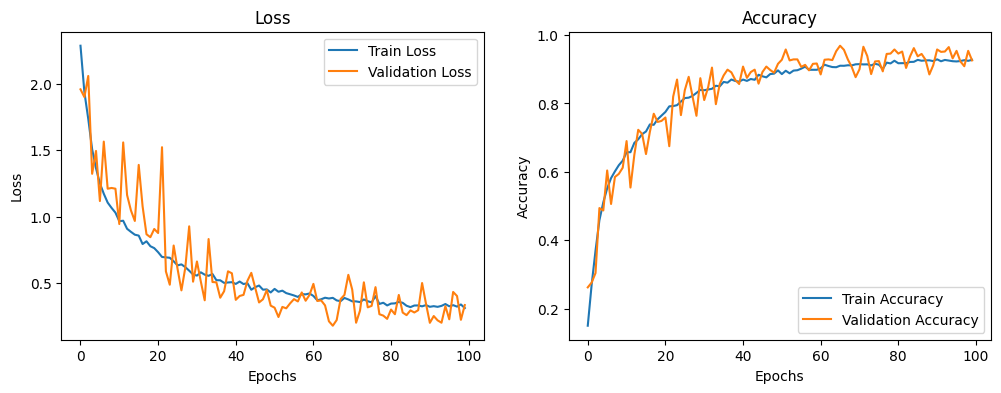

In [21]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Found 1000 images belonging to 10 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


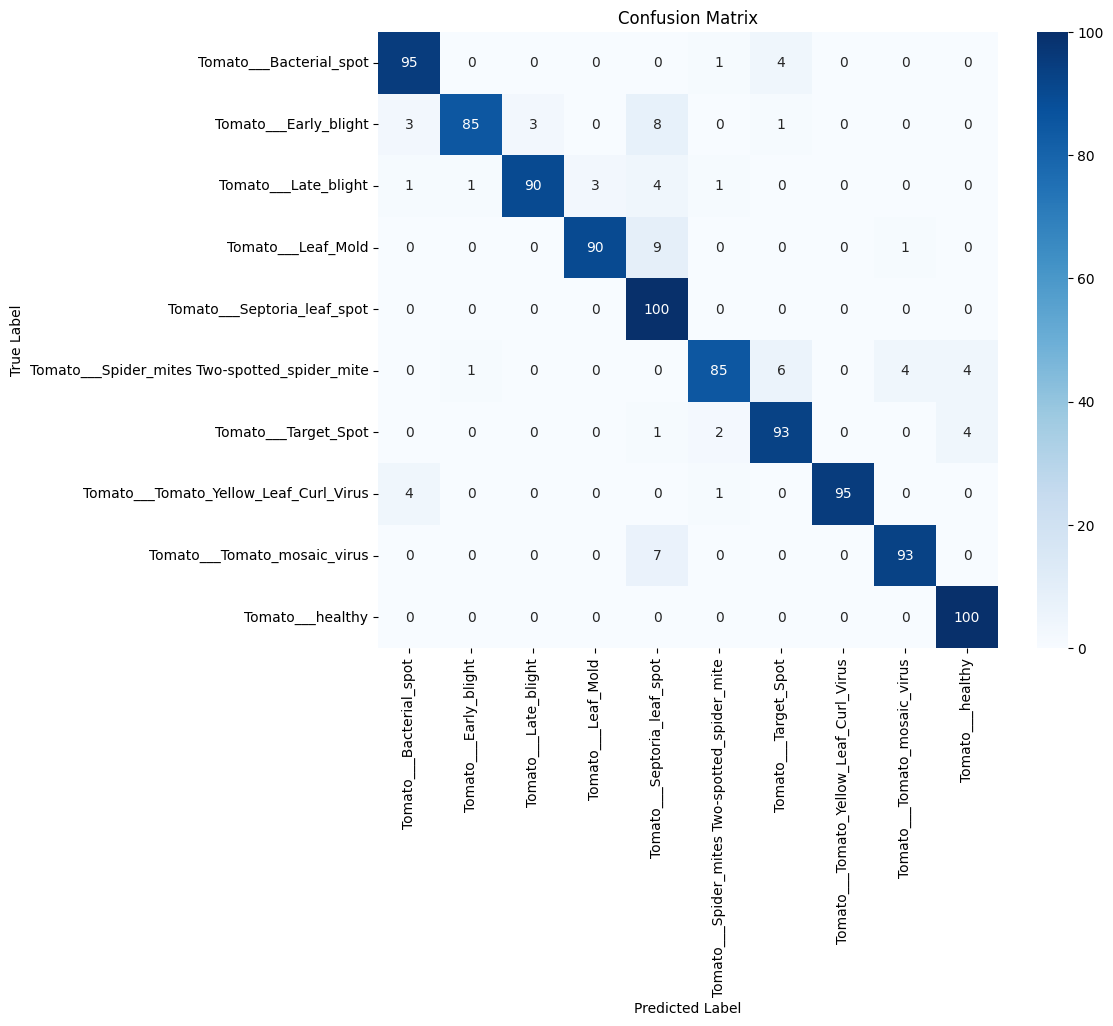

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.92      0.95      0.94       100
                        Tomato___Early_blight       0.98      0.85      0.91       100
                         Tomato___Late_blight       0.97      0.90      0.93       100
                           Tomato___Leaf_Mold       0.97      0.90      0.93       100
                  Tomato___Septoria_leaf_spot       0.78      1.00      0.87       100
Tomato___Spider_mites Two-spotted_spider_mite       0.94      0.85      0.89       100
                         Tomato___Target_Spot       0.89      0.93      0.91       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.95      0.97       100
                 Tomato___Tomato_mosaic_virus       0.95      0.93      0.94       100
                             Tomato___healthy       0.93      1.00      0.96       100

                  

In [22]:
# Load model yang sudah dilatih
model = tf.keras.models.load_model('tomato_disease_classifier_revised.h5')

# Mendefinisikan ulang generator untuk data validasi tanpa augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
        val_dir,  # Ganti dengan path direktori data validasi
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

# Mendapatkan prediksi dari model
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label sebenarnya
y_true = validation_generator.classes

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
class_report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print('Classification Report:')
print(class_report)

In [51]:
# Path ke gambar yang ingin diuji
img_path = '/content/tomato/val/Tomato___Early_blight/Tomato___Early_blight_original_1c9e0f1a-7314-449c-9482-9059684ac82d___RS_Erly.B 7840.JPG_949a751a-4ac4-45d5-b63f-4da85982c869.JPG'  # Ganti dengan path gambar yang ingin diuji

# Memuat gambar dan menyesuaikan ukurannya
img = image.load_img(img_path, target_size=(150, 150))

# Mengubah gambar menjadi larik numpy
img_array = image.img_to_array(img)

# Menambahkan dimensi batch (karena model memerlukan input batch)
img_array = np.expand_dims(img_array, axis=0)

# Melakukan prediksi
predictions = model.predict(img_array)

# Mendapatkan indeks kelas dengan probabilitas tertinggi
predicted_class = np.argmax(predictions)

# Mendapatkan nama folder dari path dataset untuk membuat daftar label
dataset_path = '/content/tomato/val'  # Ganti dengan path ke folder train yang berisi folder kelas
label_names = sorted(os.listdir(dataset_path))
print(label_names)

# Mendapatkan label kelas berdasarkan indeks prediksi
predicted_label = label_names[predicted_class]

print("Predicted class:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Predicted class: Tomato___Early_blight


In [56]:
!tensorflowjs_converter --input_format=keras \
                        --output_format=tfjs_layers_model \
                        /content/tomato_disease_classifier_revised.h5 \
                        /content/tfjs_model

2024-11-30 03:28:01.064079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732937281.085964   43370 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732937281.092390   43370 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
